# ROHP-PAZ Data exploration and modelling

### Ignacio Cobas, Didac Gallego (UAB)

## Introduction

### Imports

In [180]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import torch


from sklearn.utils import resample
from imblearn.over_sampling import SMOTE


from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, PolynomialFeatures


from sklearn.linear_model import TweedieRegressor, PassiveAggressiveRegressor, LogisticRegression, Ridge
from sklearn.linear_model import Lasso, ElasticNet, LassoLars, LinearRegression, BayesianRidge, ARDRegression
from sklearn.linear_model import SGDRegressor, RANSACRegressor, HuberRegressor, QuantileRegressor

from sklearn.cluster import KMeans

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, Matern
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


from sklearn.metrics import mean_squared_error

from time import time

import copy

### Data loading

In [2]:
metadata = pd.read_pickle(r'../data/paz_metadata.pkl')
profiles = pd.read_pickle(r'../data/paz_profiles.pkl')
refractivity = pd.read_pickle(r'../data/paz_refractivity.pkl') 
Pres = pd.read_pickle(r'../data/paz_thermo_wet_Pres.pkl')
Temp = pd.read_pickle(r'../data/paz_thermo_wet_Temp.pkl')
Vp = pd.read_pickle(r'../data/paz_thermo_wet_Vp.pkl')

## Data visualization

### Data description

#### metadata

In [3]:
metadata.head()

,roid,lat,lon,startimeUTC,az_surf,meanP_2,precipBelow12,irTemp_2,irTemp_below,dphi_0010,region,height_flag_comb
0,PAZ1.2018.130.20.55.G18,37.48,126.10,2018-05-10 20:55:41,-30.59,0.00,0.001,248,236,-0.055016,1,0.00000
1,PAZ1.2018.130.21.01.G19,4.68,153.15,2018-05-10 21:01:40,61.29,0.03,0.044,241,211,-0.017083,2,0.00000
2,PAZ1.2018.130.21.10.G24,-16.88,135.77,2018-05-10 21:10:33,19.90,0.00,0.001,231,242,-0.065611,0,2.88408
3,PAZ1.2018.130.21.16.G10,-36.43,112.66,2018-05-10 21:16:14,-7.23,0.00,0.000,283,251,0.020166,1,0.00000
4,PAZ1.2018.130.21.39.G29,-53.91,-64.58,2018-05-10 21:39:06,-147.99,0.01,0.004,248,228,0.030036,1,2.05813


In [4]:
metadata.describe()

,lat,lon,az_surf,meanP_2,precipBelow12,irTemp_2,irTemp_below,dphi_0010,region,height_flag_comb
count,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000
mean,-3.716742,-10.709305,30.281494,0.121057,0.120411,255.879933,252.496599,0.207076,1.197185,0.710863
std,35.406553,107.529302,104.249210,0.552745,0.472742,23.346265,23.060704,8.454202,1.189784,1.067363
min,-54.990000,-180.000000,-180.000000,-4.000000,-4.000000,160.000000,167.000000,-999.000000,0.000000,-2.000000
25%,-36.690000,-104.607500,-8.380000,0.000000,0.000000,238.000000,235.000000,-0.152948,1.000000,0.000000
50%,-10.290000,-24.010000,31.160000,0.000000,0.001000,258.000000,252.000000,0.089501,1.000000,0.000000
75%,29.530000,86.457500,136.990000,0.020000,0.035000,277.000000,273.000000,0.384151,1.000000,1.629630
max,54.990000,180.000000,180.000000,26.660000,17.125000,314.000000,312.000000,32.100500,5.000000,3.499640


#### profiles

In [5]:
profiles.head()

,roid,h020,h022,h024,h026,h028,h030,h032,h034,h036,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
1,PAZ1.2018.130.21.42.G26,-1.09681,-2.445270,0.370995,-0.219867,2.244140,1.955010,1.483930,1.251220,1.598810,...,-0.036065,-0.149420,-0.197623,0.014194,0.009835,0.055199,-0.058731,-0.025363,0.010424,-0.136043
3,PAZ1.2018.130.23.29.G07,NaN,NaN,NaN,NaN,NaN,NaN,2.049420,1.462710,0.054565,...,0.093193,0.029790,-0.031303,-0.010580,-0.119284,-0.095478,-0.094646,-0.187479,-0.096793,-0.019154
9,PAZ1.2018.130.21.53.G05,NaN,NaN,NaN,-0.138501,0.871127,0.882981,1.782420,1.772520,0.512098,...,0.088846,-0.051150,-0.125904,-0.149711,0.007814,-0.038109,0.026671,0.156902,0.002178,0.025415
12,PAZ1.2018.130.21.39.G29,2.87392,0.652973,0.651900,-0.121561,-0.848837,0.227879,-0.525603,-0.434966,-0.208949,...,0.352495,0.325071,0.270465,-0.019309,-0.147347,-0.041957,0.021939,0.169820,0.401755,0.661644
15,PAZ1.2018.130.22.53.G31,7.74517,5.810380,7.534330,7.985820,-5.281560,1.253270,3.316480,3.386730,3.483010,...,0.244428,-0.041983,-0.190033,-0.393716,-0.244994,-0.043441,0.068149,0.265175,0.405946,0.534125


In [6]:
profiles.describe()

,h020,h022,h024,h026,h028,h030,h032,h034,h036,h038,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
count,69070.000000,71530.000000,73811.000000,75685.000000,77212.000000,78393.000000,79502.000000,80190.000000,80696.000000,81218.000000,...,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000,84986.000000
mean,0.491114,0.476273,0.454134,0.437223,0.423723,0.406243,0.400848,0.392430,0.378216,0.373115,...,0.001759,0.000524,-0.000284,-0.001053,-0.001325,-0.002216,-0.003279,-0.002555,-0.002632,-0.001922
std,2.059456,1.977210,1.869412,1.805811,1.732094,1.674123,1.611949,1.536920,1.503112,1.487726,...,0.383299,0.377430,0.373685,0.369527,0.364648,0.361011,0.358887,0.355809,0.353179,0.351472
min,-23.738600,-21.242400,-27.726800,-16.493100,-28.749800,-19.353400,-17.009900,-9.184820,-4.867020,-4.490090,...,-8.543080,-8.178240,-7.467280,-6.973880,-6.458960,-6.140930,-6.014000,-5.542470,-5.222010,-4.861630
25%,-0.475956,-0.454610,-0.433591,-0.423995,-0.400350,-0.390903,-0.373446,-0.354187,-0.350976,-0.335212,...,-0.246117,-0.244617,-0.244572,-0.243947,-0.241033,-0.240495,-0.239773,-0.238904,-0.236055,-0.234718
50%,0.246142,0.228027,0.208413,0.190773,0.173878,0.167341,0.154294,0.145343,0.135165,0.129046,...,-0.001152,-0.000989,-0.002175,-0.002899,-0.002986,-0.002011,-0.003870,-0.003394,-0.003794,-0.003281
75%,1.111282,1.057127,0.980892,0.919378,0.857932,0.813069,0.773727,0.744533,0.702510,0.675850,...,0.246287,0.243340,0.241465,0.237873,0.236500,0.234770,0.231732,0.232236,0.229926,0.231633
max,57.904300,56.014500,52.581400,51.360200,47.411000,45.603300,42.159700,39.174600,35.647600,33.781700,...,5.901610,5.521850,4.975710,4.499640,4.181540,3.812950,3.521430,3.058170,2.691330,2.130050


#### refractivity

In [7]:
refractivity.head()

,roid,h020,h022,h024,h026,h028,h030,h032,h034,h036,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
0,PAZ1.2018.130.22.50.G25,228.839,225.547,222.815,220.260,217.183,211.219,207.209,201.853,196.929,...,51.5438,49.8845,48.3191,46.8733,45.5508,44.2749,42.9986,41.7589,40.6193,39.5591
1,PAZ1.2018.130.21.39.G29,229.724,224.876,219.906,214.477,210.073,205.915,201.247,197.103,192.822,...,47.0849,45.5853,44.1908,42.8528,41.5332,40.2342,38.9756,37.7735,36.6354,35.5577
7,PAZ1.2018.130.21.16.G10,228.471,225.045,221.836,221.962,214.745,210.808,204.393,201.035,196.044,...,51.6280,49.9044,48.3029,46.7910,45.3744,44.0683,42.8802,41.7653,40.6332,39.4444
10,PAZ1.2018.130.20.55.G18,228.571,222.429,216.544,211.031,209.125,202.560,198.375,196.169,191.705,...,52.7661,51.0457,49.3857,47.8109,46.3531,44.9786,43.6063,42.2044,40.8449,39.6448
12,PAZ1.2018.130.21.01.G19,281.826,267.698,260.278,256.801,250.271,240.659,235.688,227.969,221.975,...,57.5309,56.1517,54.7245,53.2481,51.7758,50.3734,49.0549,47.7694,46.4778,45.1863


In [8]:
refractivity.describe()

,h020,h022,h024,h026,h028,h030,h032,h034,h036,h038,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
count,75561.000000,77325.000000,78610.000000,79560.000000,80252.000000,80757.000000,81141.000000,81421.000000,81638.000000,81812.000000,...,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000
mean,246.205539,239.024894,232.327120,226.035252,220.075172,214.398254,208.987141,203.823086,198.824379,193.979502,...,52.545865,51.055297,49.599030,48.175821,46.784235,45.422827,44.090376,42.785809,41.508007,40.255743
std,16.151286,15.382333,14.564658,13.747025,12.960147,12.231440,11.534534,10.873234,10.240546,9.624100,...,4.253726,4.211916,4.162296,4.104837,4.039483,3.966488,3.886274,3.799057,3.704734,3.603057
min,172.462000,169.493000,168.401000,167.876000,169.664000,165.981000,163.529000,162.771000,156.334000,151.382000,...,40.435300,39.254800,37.940700,36.151600,34.747600,33.655000,32.711200,31.817100,31.014700,30.366300
25%,234.530000,227.846000,221.745000,216.014500,210.689000,205.539000,200.643000,195.975000,191.427000,187.028000,...,48.831500,47.367175,45.950550,44.566350,43.225575,41.931150,40.666450,39.437350,38.244875,37.084075
50%,243.174000,236.082000,229.492500,223.313000,217.467500,211.895000,206.614000,201.577000,196.687500,191.961000,...,53.269100,51.693900,50.165450,48.687750,47.231300,45.830550,44.451200,43.108850,41.795300,40.516300
75%,255.507000,247.726000,240.423000,233.583000,227.021500,220.895000,215.076000,209.527000,204.123750,198.883000,...,56.694500,55.178200,53.678325,52.191800,50.736200,49.287900,47.862725,46.457200,45.070000,43.699600
max,312.432000,309.760000,305.519000,301.504000,296.668000,295.605000,291.758000,288.263000,283.286000,271.798000,...,66.030700,64.352800,62.595600,60.710700,58.772200,57.058700,55.750200,54.679800,53.495700,51.804600


#### Pres

In [9]:
Pres.head()

,roid,h020,h022,h024,h026,h028,h030,h032,h034,h036,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
0,PAZ1.2018.130.22.50.G25,809.779,790.420,771.446,752.837,734.577,716.672,699.113,681.894,665.038,...,142.649,138.208,133.909,129.742,125.696,121.763,117.943,114.233,110.628,107.1180
1,PAZ1.2018.130.21.39.G29,786.016,766.121,746.710,727.751,709.209,691.047,673.270,655.869,638.843,...,130.946,126.882,122.945,119.128,115.427,111.842,108.369,105.005,101.743,98.5785
7,PAZ1.2018.130.21.16.G10,809.820,790.439,771.432,752.773,734.491,716.586,699.047,681.881,665.063,...,142.799,138.354,134.055,129.892,125.857,121.942,118.136,114.431,110.825,107.3200
10,PAZ1.2018.130.20.55.G18,803.266,784.118,765.361,746.974,728.934,711.239,693.898,676.894,660.218,...,144.556,140.011,135.614,131.358,127.236,123.238,119.360,115.603,111.968,108.4460
12,PAZ1.2018.130.21.01.G19,802.872,784.216,765.930,747.996,730.407,713.163,696.255,679.667,663.392,...,152.550,147.584,142.740,138.021,133.434,128.970,124.628,120.397,116.281,112.2750


In [10]:
Pres.describe()

,h020,h022,h024,h026,h028,h030,h032,h034,h036,h038,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
count,79119.000000,79926.000000,80538.000000,80963.000000,81289.000000,81543.000000,81721.000000,81894.000000,82042.000000,82167.000000,...,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000
mean,797.207746,778.072652,759.312170,740.920458,722.896282,705.235424,687.935562,670.994123,654.398833,638.144321,...,143.659749,139.125270,134.719990,130.440902,126.285206,122.250178,118.333218,114.531898,110.843756,107.266528
std,11.041273,11.281949,11.532936,11.788005,12.035733,12.276772,12.514877,12.741445,12.958307,13.167262,...,8.436893,8.081977,7.731182,7.385294,7.045206,6.711712,6.385573,6.067585,5.758415,5.458804
min,715.160000,699.182000,683.466000,668.006000,652.740000,637.672000,622.986000,606.587000,590.125000,574.173000,...,111.098000,107.534000,104.084000,100.748000,97.524200,94.408200,91.395700,88.484900,85.671200,82.950800
25%,792.611500,773.203250,754.166250,735.475500,717.123000,699.150500,681.538000,664.329000,647.458000,630.957000,...,137.073750,132.854750,128.770000,124.806750,120.955000,117.234000,113.617000,110.110000,106.708750,103.409000
50%,801.256000,782.367500,763.820000,745.648000,727.820000,710.315000,693.140000,676.336000,659.839500,643.679000,...,145.537000,140.948000,136.491000,132.166000,127.969000,123.881500,119.937000,116.104000,112.388500,108.780000
75%,804.505000,785.619000,767.139000,749.031000,731.288000,713.907500,696.892000,680.219000,663.880000,647.878000,...,151.367000,146.470000,141.704000,137.067000,132.564000,128.182000,123.929000,119.798000,115.789000,111.903000
max,872.021000,850.592000,829.601000,836.825000,817.165000,797.905000,779.033000,760.540000,742.420000,724.665000,...,161.647000,155.947000,150.399000,145.009000,140.171000,135.688000,131.312000,127.042000,122.883000,118.836000


#### Temp

In [11]:
Temp.head()

,roid,h020,h022,h024,h026,h028,h030,h032,h034,h036,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
0,PAZ1.2018.130.22.50.G25,282.284,281.199,279.875,278.301,276.752,275.475,273.887,272.737,271.590,...,214.790,215.010,215.063,214.802,214.163,213.420,212.870,212.270,211.363,210.142
1,PAZ1.2018.130.21.39.G29,266.461,266.437,265.956,265.264,264.011,262.649,261.492,260.237,259.037,...,215.821,215.992,215.902,215.731,215.673,215.721,215.771,215.728,215.512,215.145
7,PAZ1.2018.130.21.16.G10,282.169,280.780,279.304,277.542,276.714,275.475,274.653,273.422,272.273,...,214.665,215.147,215.379,215.436,215.258,214.736,213.798,212.625,211.657,211.147
10,PAZ1.2018.130.20.55.G18,283.002,282.130,281.044,279.778,278.042,276.938,275.554,274.009,272.535,...,212.624,212.878,213.106,213.230,213.009,212.653,212.424,212.567,212.736,212.270
12,PAZ1.2018.130.21.01.G19,288.151,287.440,286.372,285.080,283.926,282.935,281.595,280.283,278.860,...,205.877,204.040,202.465,201.197,200.026,198.729,197.139,195.627,194.143,192.828


In [12]:
Temp.describe()

,h020,h022,h024,h026,h028,h030,h032,h034,h036,h038,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
count,79119.000000,79926.000000,80538.000000,80963.000000,81289.000000,81543.000000,81721.000000,81894.000000,82042.000000,82167.000000,...,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000
mean,280.228762,279.160210,278.057891,276.949998,275.833730,274.756167,273.663857,272.532889,271.407536,270.258226,...,212.621462,211.965029,211.321359,210.696383,210.091974,209.516979,208.967027,208.463127,207.989097,207.571022
std,10.099373,9.913802,9.781600,9.699785,9.627385,9.594387,9.604145,9.588219,9.596606,9.624110,...,6.068142,6.453553,6.849448,7.244463,7.633741,8.008268,8.377295,8.714276,9.041945,9.328999
min,234.148000,233.164000,234.158000,233.086000,231.095000,229.525000,228.487000,227.203000,226.534000,226.401000,...,186.436000,187.432000,185.269000,184.541000,183.008000,179.831000,177.247000,175.971000,174.442000,173.289000
25%,273.120000,272.146000,271.168000,270.100000,269.079000,268.030000,266.963000,265.862000,264.782000,263.613500,...,207.417000,206.274000,205.152000,204.074000,203.052000,202.070750,201.143000,200.309000,199.568000,198.886000
50%,282.424000,281.443000,280.394000,279.336000,278.219000,277.150000,276.105000,274.985000,273.892000,272.774000,...,211.423500,210.875000,210.388000,209.937000,209.469000,209.018500,208.601000,208.238000,207.902000,207.575500
75%,288.259500,287.254750,286.210750,285.145000,284.040000,282.962000,281.870000,280.711000,279.566000,278.400000,...,217.239250,217.008000,216.769000,216.529000,216.310000,216.102000,215.909250,215.731000,215.579000,215.442000
max,331.318000,322.591000,310.933000,309.291000,303.789000,297.355000,296.991000,295.130000,292.504000,295.093000,...,236.735000,236.927000,238.299000,243.060000,245.984000,247.020000,247.248000,247.308000,246.800000,245.240000


#### Vp

In [13]:
Vp.head()

,roid,h020,h022,h024,h026,h028,h030,h032,h034,h036,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
0,PAZ1.2018.130.22.50.G25,1.364010,1.621750,1.890060,2.157550,2.292920,1.883550,1.863100,1.538140,1.334780,...,0.000954,0.000831,0.000724,0.000632,0.000554,0.000516,0.000486,0.000458,0.000431,0.000407
1,PAZ1.2018.130.21.39.G29,0.175622,0.321243,0.388881,0.303473,0.302557,0.309994,0.274984,0.281953,0.259538,...,0.000535,0.000502,0.000477,0.000461,0.000444,0.000428,0.000412,0.000397,0.000384,0.000385
7,PAZ1.2018.130.21.16.G10,1.217430,1.405180,1.614040,2.407110,1.759320,1.850400,1.427540,1.485760,1.283790,...,0.000987,0.000854,0.000739,0.000641,0.000560,0.000520,0.000490,0.000462,0.000436,0.000410
10,PAZ1.2018.130.20.55.G18,1.796720,1.463600,1.112740,0.770508,1.150090,0.664193,0.570921,0.845821,0.757182,...,0.001481,0.001213,0.000993,0.000813,0.000667,0.000570,0.000541,0.000513,0.000486,0.000461
12,PAZ1.2018.130.21.01.G19,14.639000,12.370800,11.566700,11.608200,10.972000,9.671800,9.263760,8.409680,7.914390,...,0.003695,0.002991,0.002366,0.001922,0.001534,0.001213,0.000965,0.000817,0.000645,0.000518


In [14]:
Vp.describe()

,h020,h022,h024,h026,h028,h030,h032,h034,h036,h038,...,h142,h144,h146,h148,h150,h152,h154,h156,h158,h160
count,79119.000000,79926.000000,80538.000000,80963.000000,81289.000000,81543.000000,81721.000000,81894.000000,82042.000000,82167.000000,...,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000,84984.000000
mean,5.426105,4.828104,4.311708,3.865789,3.476094,3.141167,2.848961,2.591633,2.357970,2.143909,...,0.001546,0.001336,0.001161,0.001014,0.000891,0.000791,0.000711,0.000654,0.000602,0.000556
std,4.089540,3.838550,3.589536,3.347761,3.112713,2.894712,2.686524,2.493972,2.310543,2.137608,...,0.001117,0.000888,0.000703,0.000555,0.000438,0.000345,0.000272,0.000223,0.000184,0.000153
min,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,...,0.000117,0.000126,0.000046,0.000001,0.000001,0.000001,0.000001,0.000001,0.000001,0.000002
25%,2.160385,1.775197,1.466980,1.219060,1.033050,0.882954,0.771833,0.679423,0.606137,0.542174,...,0.000671,0.000633,0.000598,0.000566,0.000539,0.000518,0.000499,0.000481,0.000462,0.000443
50%,4.252000,3.646010,3.136540,2.729660,2.374930,2.072000,1.828840,1.624515,1.445985,1.283540,...,0.001106,0.000992,0.000891,0.000801,0.000723,0.000663,0.000619,0.000583,0.000549,0.000514
75%,7.863925,7.027600,6.309085,5.686690,5.138150,4.651260,4.215130,3.828737,3.463312,3.120715,...,0.002171,0.001859,0.001605,0.001383,0.001188,0.001019,0.000886,0.000794,0.000714,0.000645
max,19.972700,18.247000,17.069500,16.364400,16.642500,14.769300,13.517200,12.898500,12.031800,11.294100,...,0.013905,0.011189,0.008990,0.007199,0.005738,0.004504,0.003509,0.002886,0.002410,0.001999


### Cleaning up data

In [15]:
# doesnt work with metadata
def cleanup(data, threshold=0.05):
    min_height = np.argmax(data.isna().mean(axis=0).values[1:] < threshold)
    
    data = pd.concat([data.iloc[:, 0], data.iloc[:, min_height:]], axis=1)
    data = data[data.notna().all(axis=1)]
    data = data.reset_index(drop=True)
    
    return data

#### metadata

In [16]:
(metadata.dphi_0010 < -2).sum()

10

In [17]:
(metadata.meanP_2 < 0).sum()

18

In [18]:
metadata = metadata[metadata.dphi_0010 > -2]
metadata = metadata[metadata.meanP_2 >= 0]

#### profiles

In [19]:
profiles = cleanup(profiles, 0.05)

#### refractivity

In [20]:
refractivity = cleanup(refractivity, 0.05)

#### Pres

In [21]:
Pres = cleanup(Pres, 0.05)

#### Temp

In [22]:
Temp = cleanup(Temp, 0.05)

#### Vp

In [23]:
Vp = cleanup(Vp, 0.05)

## Data transformation

### Changing column names

In [24]:
profiles_columns = ('profiles_' + profiles.columns[1:]).tolist()
profiles_columns.insert(0, 'roid')
profiles_columns = dict( zip(profiles.columns, profiles_columns) )

In [25]:
profiles = profiles.rename(columns=profiles_columns)

In [26]:
refractivity_columns = ('refractivity_' + refractivity.columns[1:]).tolist()
refractivity_columns.insert(0, 'roid')
refractivity_columns = dict( zip(refractivity.columns, refractivity_columns) )

In [27]:
refractivity = refractivity.rename(columns=refractivity_columns)

In [28]:
Pres_columns = ('Pres_' + Pres.columns[1:]).tolist()
Pres_columns.insert(0, 'roid')
Pres_columns = dict( zip(Pres.columns, Pres_columns) )

In [29]:
Pres = Pres.rename(columns=Pres_columns)

In [30]:
Temp_columns = ('Temp_' + Temp.columns[1:]).tolist()
Temp_columns.insert(0, 'roid')
Temp_columns = dict( zip(Temp.columns, Temp_columns) )

In [31]:
Temp = Temp.rename(columns=Temp_columns)

In [32]:
Vp_columns = ('Vp_' + Vp.columns[1:]).tolist()
Vp_columns.insert(0, 'roid')
Vp_columns = dict( zip(Vp.columns, Vp_columns) )

In [33]:
Vp = Vp.rename(columns=Vp_columns)

### Merging all data

In [34]:
data = [profiles, refractivity, Pres, Temp, Vp]
data_columns = [profiles_columns, refractivity_columns, Pres_columns, Temp_columns, Vp_columns]

In [35]:
min_height = 2 + 0.2*(72-min([len(c) for c in data_columns]))
if min_height >= 10:
    start_name = 'h' + str(int(min_height * 10))
else:
    start_name = 'h' + '0' + str(int(min_height * 10))

In [36]:
for i in range(len(data)):
    index = list(data_columns[i].keys()).index(start_name)
    data[i] = data[i].drop(columns=data[i].columns[1:index])

In [37]:
profiles, refractivity, Pres, Temp, Vp = data

In [582]:
# ['az_surf', 'meanP_2', 'precipBelow12', 'irTemp_below', 'startimeUTC', 'dphi_0010', 'region', 'height_flag_comb']
full_data = metadata.merge(profiles).merge(refractivity).merge(Pres).merge(Temp).merge(Vp).drop(['az_surf', 'precipBelow12', 'irTemp_below', 'startimeUTC', 'dphi_0010', 'region', 'height_flag_comb'], axis=1)

In [583]:
print(full_data.shape)
full_data.head()

(79626, 320)


,roid,lat,lon,meanP_2,irTemp_2,profiles_h036,profiles_h038,profiles_h040,profiles_h042,profiles_h044,...,Vp_h142,Vp_h144,Vp_h146,Vp_h148,Vp_h150,Vp_h152,Vp_h154,Vp_h156,Vp_h158,Vp_h160
0,PAZ1.2018.130.20.55.G18,37.48,126.10,0.00,248,-0.106622,-0.169008,1.897890,1.593650,2.531510,...,0.001481,0.001213,0.000993,0.000813,0.000667,0.000570,0.000541,0.000513,0.000486,0.000461
1,PAZ1.2018.130.21.01.G19,4.68,153.15,0.03,241,-0.358579,0.625408,-0.823484,-0.457033,0.424057,...,0.003695,0.002991,0.002366,0.001922,0.001534,0.001213,0.000965,0.000817,0.000645,0.000518
2,PAZ1.2018.130.21.10.G24,-16.88,135.77,0.00,231,-0.722735,-0.492319,0.358507,-0.264436,0.682555,...,0.002862,0.002370,0.001966,0.001630,0.001351,0.001120,0.000946,0.000843,0.000752,0.000670
3,PAZ1.2018.130.21.16.G10,-36.43,112.66,0.00,283,-0.855325,-0.502248,-0.352526,-0.611806,-1.137040,...,0.000987,0.000854,0.000739,0.000641,0.000560,0.000520,0.000490,0.000462,0.000436,0.000410
4,PAZ1.2018.130.21.39.G29,-53.91,-64.58,0.01,248,-0.208949,-0.162441,0.417120,0.428870,0.740477,...,0.000535,0.000502,0.000477,0.000461,0.000444,0.000428,0.000412,0.000397,0.000384,0.000385


In [584]:
val_data = full_data.iloc[int(full_data.shape[0]*0.7):]
val_data = val_data.reset_index(drop = True)

In [585]:
full_data = full_data.iloc[:int(full_data.shape[0]*0.7)]

### Selecting columns and rows

In [589]:
def get_data_height(full_data, min_height, max_height=None, n_cols = 1):  
    if max_height is None:
        max_height = min_height + 1

    min_min_height = int(full_data.columns[5][-3:])
    max_max_height = int(full_data.columns[-1][-3:])

        
    shift = int((max_max_height - min_min_height) / 2 + 1)

    if min_height >= 100:
        start_name = 'profiles_h' + str(int(min_height))
    else:
        start_name = 'profiles_h' + '0' + str(int(min_height))

    start = np.where(full_data.columns == start_name)[0][0]

    data_columns = [full_data.columns[start+shift*i:start+shift*i+n_cols].tolist() for i in range(5)]
    data_columns = sum(data_columns, ['lat', 'lon', 'irTemp_2', 'meanP_2']) # flatten and add columns lat lon irTemp_2 meanP_2

    data = full_data.loc[:, data_columns]
    
    return data


def get_y_column(data, height):
    if height >= 100:
        y_name = 'profiles_h' + str(int(height))
    else:
        y_name = 'profiles_h' + '0' + str(int(height))
    y_column = np.where(data.columns == y_name)[0][0]
    
    return y_column

In [590]:
height = 44

In [591]:
data = get_data_height(full_data, height)

In [592]:
data.head()

,lat,lon,irTemp_2,meanP_2,profiles_h044,refractivity_h044,Pres_h044,Temp_h044,Vp_h044
0,37.48,126.10,248,0.00,2.531510,183.617,596.561,265.545,1.856050
1,4.68,153.15,241,0.03,0.424057,196.695,601.356,273.844,5.352540
2,-16.88,135.77,231,0.00,0.682555,172.490,603.802,276.874,0.660795
3,-36.43,112.66,283,0.00,-1.137040,181.244,601.075,266.696,1.221930
4,-53.91,-64.58,248,0.01,0.740477,176.416,574.440,254.722,0.246696


## Model

### Linear regressors

In [46]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [47]:
y_column = get_y_column(data, height)

In [48]:
X = np.concatenate([data_scaled[:, :y_column], data_scaled[:, y_column+1:]], axis=1)
y = data_scaled[:, y_column]

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
regressors = [TweedieRegressor(), PassiveAggressiveRegressor(), Ridge(), Lasso(), LassoLars(), ElasticNet(), LinearRegression(), BayesianRidge(), ARDRegression(), SGDRegressor(), RANSACRegressor(), HuberRegressor()]

In [51]:
error_regressors = []
for reg in regressors:
    reg.fit(X_train, y_train)
    error_regressors.append(mean_squared_error(reg.predict(X_test), y_test))
error_regressors

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:133: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  warnings.warn(


[0.822681398050304,
 1.0538750959248673,
 0.8149068341262642,
 0.9578349842434303,
 0.9578349842434303,
 0.9578349842434303,
 0.8165581675070427,
 0.8161051395440856,
 0.8166541395790358,
 0.8005861307417612,
 0.8530459694270068,
 0.8407841998558442]

In [52]:
reg = regressors[np.argmin(error_regressors)]
reg

SGDRegressor()

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

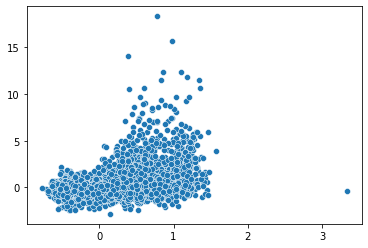

In [53]:
sns.scatterplot(reg.predict(X_test), y_test)

### Polynomial regressor

In [54]:
error = []

for d in range(1, 5):
    poly = PolynomialFeatures(degree=d)
    poly = poly.fit_transform(X)
    
    X_train, X_test, y_train, y_test = train_test_split(poly, y)
    
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    
    error.append(mean_squared_error(reg.predict(X_test), y_test))
error

[0.8018896617623393, 0.7451327461177967, 0.7826298851912422, 198926.5133556111]

In [55]:
poly = PolynomialFeatures(degree=np.argmin(error) + 1) # 3 seems to be the best, anything bigger than 5 is really bad
X_poly = poly.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_poly, y)

reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [56]:
mean_squared_error(reg.predict(X_test), y_test)

0.7473865450198953

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

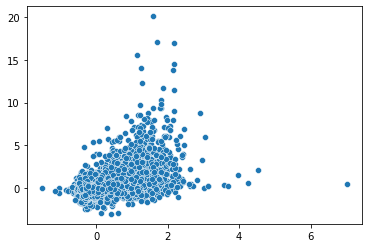

In [57]:
sns.scatterplot(reg.predict(X_test), y_test)

### Classificators

In [58]:
def classify_data(data, height=12, profile_threshold=4):
    if height >= 100:
        profile = 'profiles_h' + str(int(height))
    else:
        profile = 'profiles_h' + '0' + str(int(height))
    
    data_classified = pd.DataFrame(data[data.columns].values, columns=data.columns)
    data_classified['rain'] = 0
    
    data_classified.loc[data_classified[profile] > profile_threshold, 'rain'] = 1
    data_classified.loc[data_classified[profile] <= profile_threshold, 'rain'] = 0
    data_classified = data_classified.drop(profile, axis=1)
    
    return data_classified

In [59]:
profile_threshold = 4

In [60]:
data.head()

,lat,lon,irTemp_2,profiles_h044,refractivity_h044,Pres_h044,Temp_h044,Vp_h044
0,37.48,126.10,248,2.531510,183.617,596.561,265.545,1.856050
1,4.68,153.15,241,0.424057,196.695,601.356,273.844,5.352540
2,-16.88,135.77,231,0.682555,172.490,603.802,276.874,0.660795
3,-36.43,112.66,283,-1.137040,181.244,601.075,266.696,1.221930
4,-53.91,-64.58,248,0.740477,176.416,574.440,254.722,0.246696


In [61]:
data_classifiers = classify_data(data, height=height, profile_threshold=profile_threshold)

X = data_classifiers.iloc[:, :-1]
y = data_classifiers.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [63]:
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    VotingClassifier(estimators=[('gnb', GaussianNB()), 
                                 ('qda1', QuadraticDiscriminantAnalysis(reg_param=0.5)),
                                 ('qda2', QuadraticDiscriminantAnalysis(reg_param=0.2))
                                
                                ], voting='hard')
]

In [64]:
error_classifiers = []
times = []
for clf in classifiers:
    st = time()
    clf.fit(X_train, y_train)
    error_classifiers.append(clf.score(X_test, y_test))
    times.append(time() - st)
print(error_classifiers)
print(times)

[0.9758880516684607, 0.9762468604233944, 0.9761750986724076, 0.9134553283100108, 0.9473986365267313, 0.9418729817007535]
[0.15169072151184082, 0.19429421424865723, 1.778691053390503, 0.009598016738891602, 0.014495611190795898, 0.1813337802886963]


In [65]:
clf = classifiers[np.argmax(error_classifiers)]
clf

RandomForestClassifier(max_depth=5, max_features=1, n_estimators=10)

In [66]:
(data_classifiers.rain == 0).mean()

0.976299831353834

The good results are probably a consequence of the imbalanced dataset, so it should be a good idea to upsample the rain class.

#### Upsampling

In [67]:
def upsample(full_data, column, value1, value2, final_size):
    data = full_data[full_data[column] == value1]
    data = torch.tensor(data[data.columns].values)
    
    data = data.transpose(-1, 0)
    data = data.view(1, data.shape[0], data.shape[1])
    
    upsampler = torch.nn.Upsample(size=final_size, mode='nearest')
    data = upsampler(data)
    
    data = data.view(data.shape[1], final_size)
    data = data.transpose(-1, 0)
    
    data = pd.DataFrame(data, columns=full_data.columns)
    data = pd.concat([data, full_data.loc[full_data[column] == value2]])
    
    return data

In [68]:
column = 'rain'
value1 = 1
value2 = 0
final_size = data_classifiers[data_classifiers.rain == 0].count()[0]

data_classifiers_train = data_classifiers[:int(data_classifiers.shape[0]*0.8)]
data_classifiers_test = data_classifiers[int(data_classifiers.shape[0]*0.8):]

data_upsampled = upsample(data_classifiers_train, column, value1, value2, final_size)

In [69]:
X = data_upsampled.iloc[:, :-1]
y = data_upsampled.iloc[:, -1]

scaler = StandardScaler()
X = scaler.fit_transform(X)

In [70]:
X_train = X
X_test = data_classifiers_test.iloc[:, :-1]
y_train = y
y_test = data_classifiers_test.iloc[:, -1]

In [71]:
error_classifiers = []
for clf in classifiers:
    clf.fit(X_train, y_train)
    error_classifiers.append(clf.score(X_test, y_test))
error_classifiers

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but QuadraticDiscriminantAnalysis was fitted without feature names
  warnings.warn(
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-pack

[0.9755113024757804,
 0.873340509508432,
 0.9755113024757804,
 0.9755113024757804,
 0.02448869752421959,
 0.9755113024757804]

In [72]:
clf = classifiers[np.argmax(error_classifiers)]
print(clf)
print(clf.score(X_test, y_test))

DecisionTreeClassifier(max_depth=5)
0.9755113024757804


/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


#### Upsampling with SMOTE

https://towardsdatascience.com/upsampling-with-smote-for-classification-projects-e91d7c44e4bf

In [73]:
def upsample_SMOTE(X_train, y_train, ratio=1.0):
    """Upsamples minority class using SMOTE.
    Ratio argument is the percentage of the upsampled minority class in relation
    to the majority class. Default is 1.0
    """
    sm = SMOTE(random_state=23, sampling_strategy=ratio)
    X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)
    return X_train_sm, y_train_sm

In [74]:
X = data_classifiers.iloc[:, :-1]
y = data_classifiers.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, y_train = upsample_SMOTE(X_train, y_train, 1.0)

In [75]:
error_classifiers = []
for clf in classifiers:
    clf.fit(X_train, y_train)
    error_classifiers.append(clf.score(X_test, y_test))
error_classifiers

[0.843415859346968,
 0.8467886616433441,
 0.8690348044492285,
 0.8532472192321493,
 0.8784355938284895,
 0.8930749910297812]

In [76]:
clf = classifiers[np.argmax(error_classifiers)]
print(clf)
print(clf.score(X_test, y_test))

VotingClassifier(estimators=[('gnb', GaussianNB()),
                             ('qda1',
                              QuadraticDiscriminantAnalysis(reg_param=0.5)),
                             ('qda2',
                              QuadraticDiscriminantAnalysis(reg_param=0.2))])
0.8930749910297812


### Best Model

#### Train

In [77]:
height = 120
profile_threshold = 4

In [78]:
data = get_data_height(full_data, height)
data = classify_data(data, height, profile_threshold)

X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train, y_train = upsample_SMOTE(X_train, y_train, 1.0)

In [79]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
clf.fit(X_train, y_train)

VotingClassifier(estimators=[('gnb', GaussianNB()),
                             ('qda1',
                              QuadraticDiscriminantAnalysis(reg_param=0.5)),
                             ('qda2',
                              QuadraticDiscriminantAnalysis(reg_param=0.2))])

In [81]:
clf.score(X_train, y_train)

0.9546456202543774

#### Test

In [82]:
clf.score(X_test, y_test)

0.9115177610333692

In [83]:
(clf.predict(X_test) == y_test).mean()

0.9115177610333692

In [84]:
(clf.predict(X_test[y_test == 1]) == 1).mean()

1.0

In [85]:
(clf.predict(X_test[y_test == 0]) == 0).mean()

0.9113969531474562

### One model per layer

In [612]:
def one_model_per_layer(full_data, parameters):
    # parameters
    profile_threshold = parameters['profile_threshold']
    max_height = parameters['max_height']
    min_height = parameters['min_height']
    step = parameters['step']
    classifier = parameters['classifier']

    # predictions = dict.fromkeys(range(min_height, max_height, step))
    # scores = dict.fromkeys(range(min_height, max_height, step))

    scores = dict.fromkeys(['Total', 'Rain1', 'Rain0'], np.array([]))
    classifiers = dict.fromkeys(range(min_height, max_height, step))
   
    # height loop
    for height in range(min_height, max_height, step):
        classifier = parameters['classifier']
        try:
            # get data
            data = get_data_height(full_data, height)
            data = classify_data(data, height, profile_threshold)

            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]
            
            X_train, X_test, y_train, y_test = train_test_split(X, y)
            
            # upsample
            data_upsampled = upsample_SMOTE(X_train, y_train, 0.5)
            
            # Train
            classifier.fit(X_train, y_train)

            # Test
            total = classifier.predict(X_test)
            rain1 = classifier.predict(X_test[y_test == 1])
            rain0 = classifier.predict(X_test[y_test == 0])
            
            # predictions[height] = {'Total': total, 'Rain1': rain1, 'Rain0': rain0}
            
            total = (total == y_test).mean()
            rain1 = (rain1 == 1).mean()
            rain0 = (rain0 == 0).mean()
            
            # scores[height] = {'Total': total, 'Rain1': rain1, 'Rain0': rain0}
            
            scores['Total'] = np.append(scores['Total'], total)
            scores['Rain1'] = np.append(scores['Rain1'], rain1)
            scores['Rain0'] = np.append(scores['Rain0'], rain0)
            
            classifiers[height] = copy.deepcopy(classifier)

        except Exception as e:
            # predictions[height] = {'Total': -1, 'Rain1': -1, 'Rain0': -1}
            # scores[height] = {'Total': 0, 'Rain1': 0, 'Rain0': 0}
            
            scores['Total'] = np.append(scores['Total'], 0)
            scores['Rain1'] = np.append(scores['Rain1'], 0)
            scores['Rain0'] = np.append(scores['Rain0'], 0)
            
            classifiers[height] = None
            
    scores = pd.DataFrame(scores)
    scores.index = range(min_height, max_height, step)
    
    return scores, classifiers #, predictions

In [594]:
classifier = VotingClassifier(estimators=[('gnb1', GaussianNB()),
                                          ('gnb2', GaussianNB()),
                                          ('gnb3', GaussianNB()),
                                          ('gnb4', GaussianNB()),
                                          ('gnb5', GaussianNB()),
                                          ('qda1', QuadraticDiscriminantAnalysis(reg_param=0.1)),
                                         ], voting='hard')

# by setting min height to 60 and max height to 140, precision goes to 80%
# at very low heights (or very high) there probably are very few rain clouds,
# which means that upsampling does not have much to start with, so it doesn't do very well

parameters = {
    'profile_threshold': 4,
    'max_height': 142,
    'min_height': 60,
    'step': 2,
    'classifier': classifier
}

In [595]:
scores, classifiers = one_model_per_layer(full_data, parameters)
# scores

In [597]:
precision_parameters = {
    'min_profile_threshold': -1,
    'max_profile_threshold': 5,
    'precision': 25,
    
    'max_height': 140,
    'min_height': 60,
    'step': 2,
}

In [598]:
def precision_model_per_layer(full_data, precision_parameters):
    min_profile_threshold = precision_parameters['min_profile_threshold']
    max_profile_threshold = precision_parameters['max_profile_threshold']
    precision = precision_parameters['precision']
    
    # list(np.linspace(min_profile_threshold, max_profile_threshold, precision))
    results = dict.fromkeys(np.linspace(min_profile_threshold, max_profile_threshold, precision))
    
    for profile_threshold in np.linspace(min_profile_threshold, max_profile_threshold, precision):
        
        parameters = {
            'profile_threshold': profile_threshold,
            'max_height': precision_parameters['max_height'],
            'min_height': precision_parameters['min_height'],
            'step': precision_parameters['step'],
            'classifier': classifier
        }
        
        scores, classifiers = one_model_per_layer(full_data, parameters)
        
        results[profile_threshold] = {'Score': scores, 'Classifiers': classifiers}

    return results

In [613]:
results = precision_model_per_layer(full_data, precision_parameters)

/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/yank/PAZ/notebooks/.venv/lib/python3.8/site-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [614]:
def predict(results, precision_parameters):
    max_height = precision_parameters['max_height']
    min_height = precision_parameters['min_height']
    step = precision_parameters['step']

    min_profile_threshold = precision_parameters['min_profile_threshold']
    max_profile_threshold = precision_parameters['max_profile_threshold']
    precision = precision_parameters['precision']

    predictions = dict.fromkeys(range(min_height, max_height, step), dict.fromkeys(np.linspace(min_profile_threshold, max_profile_threshold, precision)))
    
    for height in range(min_height, max_height, step):
        for profile_threshold in np.linspace(min_profile_threshold, max_profile_threshold, precision):
            data = get_data_height(val_data, height)
            data = classify_data(data, height, profile_threshold)

            classifier = results[profile_threshold]['Classifiers'][height]

            X = data.iloc[:, :-1]
            y = data.iloc[:, -1]

            try:
                predictions[height][profile_threshold] = copy.deepcopy(classifier.predict(X))
            except AttributeError:
                predictions[height][profile_threshold] = None

        # if prediction is 1, means its higher than that threshold
        # so we sum to know how many 'higher than' we got
        # its not perfect, because its not 100% true that
        # when a classifier says higher, the last one said higher as well
        # but i have seen that it was more than 95% likely
        # and this allows me to simplify this very much
        predictions[height] = pd.DataFrame(predictions[height]).sum(axis=1)

        profile_thresholds = list(results.keys())

        # profile thresholds are now the values in between the thresholds, so we add one more to the end of the list
        profile_thresholds -= (profile_thresholds[1] - profile_thresholds[0])/2
        profile_thresholds = np.append(profile_thresholds, profile_thresholds[-1] + 2*(profile_thresholds[1] - profile_thresholds[0])/2)

        # transforming from one linear space to another one
        # profile_threshold = m * prediction + n
        m = profile_thresholds[1] - profile_thresholds[0]
        n = profile_thresholds.min()

        predictions[height] *= m
        predictions[height] += n
    
    predictions = pd.DataFrame(predictions)
    
    return predictions

In [615]:
predictions = predict(results, precision_parameters)

In [629]:
predictions

,60,62,64,66,68,70,72,74,76,78,...,120,122,124,126,128,130,132,134,136,138
0,-0.375,-0.625,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
1,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
2,-0.625,-0.625,-0.625,-0.625,-0.625,-0.625,-0.375,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
3,-0.625,-0.625,-0.625,-0.625,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
4,-0.625,-0.625,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23883,-0.625,-0.875,-0.875,-1.125,-0.875,-0.625,-0.625,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
23884,-0.625,-0.875,-0.625,-0.875,-0.875,-0.625,-0.625,-0.375,-0.375,-0.375,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
23885,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125
23886,-0.625,-0.625,-0.625,-0.625,-0.625,-0.625,-0.375,-0.375,-0.125,-0.125,...,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125,-0.125


In [645]:
rainy = []
for i in range(predictions.shape[0]):
    if (predictions.iloc[i] > 4).sum() > 5:
        rainy.append(i)
print(len(rainy))

1571


profiles_h058    0.751034
profiles_h060      0.4757
profiles_h062    0.476445
profiles_h064     0.81929
profiles_h066    0.655859
profiles_h068     1.22023
profiles_h070     1.79034
profiles_h072    0.278431
profiles_h074     2.41018
profiles_h076       2.342
profiles_h078     2.48406
profiles_h080     2.00869
profiles_h082      2.0807
profiles_h084     1.89589
profiles_h086     1.85662
profiles_h088    0.976346
profiles_h090    0.788675
profiles_h092     1.21385
profiles_h094      1.5168
profiles_h096     1.17425
profiles_h098     1.39275
profiles_h100     1.76338
profiles_h102     1.55531
profiles_h104    0.904408
profiles_h106    0.628832
profiles_h108    0.731321
profiles_h110    0.584498
profiles_h112    0.211538
profiles_h114    0.356096
profiles_h116    0.389642
profiles_h118    0.504764
profiles_h120    0.190652
profiles_h122    0.095194
profiles_h124   -0.048989
profiles_h126    0.218328
profiles_h128    0.429671
profiles_h130    0.574572
profiles_h132    0.823814
profiles_h13

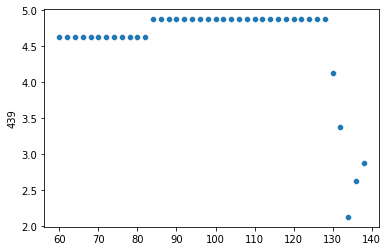

In [653]:
i = 24
sns.scatterplot(x=predictions.iloc[rainy[i]].index, y=predictions.iloc[rainy[i]])
val_data.iloc[rainy[i]][val_data.columns[16:56]]

0